<a href="https://colab.research.google.com/github/yoance/HPINN/blob/main/H-PINN%20-%20Heat%20Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Heat Equation

# 1. Import the required Library and Package.

The code can be run with TensorFlow version `2.5.x`.
The model implementation is done with the library NumPy and the library for machine learning TensorFlow.

A class implementation has been developed for creating the PINN as an object of Keras in a package stored in the file `PINNPDESolver.py`.

Computation is performed on Google Colab.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Current Working Directory
dir = '/content/drive/My Drive/Tugas Akhir/Colab'

import sys
sys.path.insert(0, dir)

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Physics-Informed Neural Network
import PINNPDESolver as pinn

# Import Combined Learning Rate Decay
from CombinedDecay import CombinedDecay

# Import time
from time import time

# Import matplotlib for plots
import matplotlib.pyplot as plt

# Creating tables
import pandas as pd
from tabulate import tabulate

Mounted at /content/drive


In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 24,               # LaTeX default is 10pt font.
    "font.size": 24,
    "legend.fontsize": 24,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
plt.rcParams.update(pgf_with_latex)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [ ]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

# 2. Heat Equation and Transformation into Loss Function

The heat equation to be used is

$$
\begin{equation}
    u_t - c^2u_{xx} = 0, \quad 0<x<l, \quad t>0,
\end{equation}
$$
with
$$
c = 1, \quad l=6.
$$
Given the initial condition (IC)
$$
\begin{equation}
    u(x,\,0) = x(l-x),
\end{equation}
$$
and boundary condition (BC)
$$
\begin{equation}
    u(0,\,t) = u(l,\,t) = 0.
\end{equation}
$$

The unique solution to this problem is
$$
\begin{equation}
		    u(x,\;t) = \sum_{n=1}^{\infty}\frac{4l^2}{n^3\pi^3} \exp{\left( -\frac{n^2\pi^2c^2t}{l^2} \right)} \sin\left(\frac{n\pi x}{l}\right) (1-(-1)^n).
		\end{equation}
$$


In [ ]:
l = 6
const_c = 1

lambda_star = - const_c ** 2

# Define initial condition
def fun_u_0(x):
    return x * (l - x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx, lambd = lambda_star):
    return u_t + lambd * u_xx

In [ ]:
# Explicit Solution

lambd_star = const_c ** 2

def u_expl(t_i, x_i):
    """Explicit Solution to the Heat Equation."""
    sum = 0
    for n in range(1,10+1):
      sum += (4*l**2/(n**3*np.pi**3)) * np.sin((n*np.pi*x_i)/l) * np.exp((-n**2*np.pi**2*const_c**2*t_i)/l**2) * (1-(-1)**n)
    return sum

In [ ]:
# Set boundary
tmin = 0.
tmax = 10.
xmin = 0.
xmax = l

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# 3. Modeling

## 1. Preparation for Modeling


### Generating Training Data and Collocation Points for Inverse Problems

In [ ]:
N_d = 500
noise = 0.0

plot = True

# Set random seed for reproducible results
tf.random.set_seed(0)

if plot == True:
  # Draw points with measurements randomly
  t_d = tf.random.uniform((N_d,1), lb[0], ub[0], dtype=DTYPE)
  x_d = tf.random.uniform((N_d,1), lb[1], ub[1], dtype=DTYPE)
  X_d = tf.concat([t_d, x_d], axis=1)

  # Explicit analytical solution
  u_d = u_expl(t_d, x_d)
  u_d += noise * tf.random.normal(u_d.shape, dtype=DTYPE)

elif plot == False:
  X_d, u_d = pinn.generate_collocation_points(N_d, lb, ub, u_expl, noise=0)

X_param = [X_d]
u_param = [u_d]

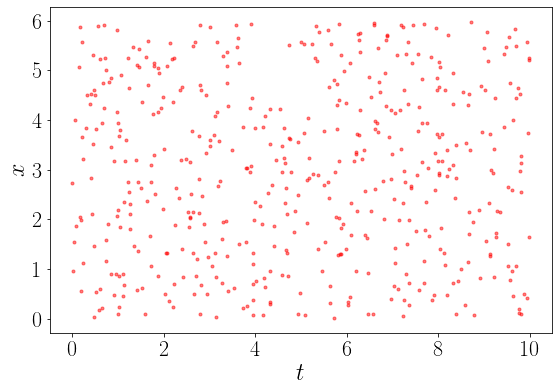

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_d, x_d, c='r', marker='.', alpha=0.5)
plt.xlabel('$t$')
plt.ylabel('$x$')

# plt.title('(b) Visualisasi koordinat data $\it{training}$ dan $\it{collocation\;points}$ untuk masalah invers persamaan panas.');
# plt.savefig('heat_eqn_inv_train.pdf', bbox_inches='tight', dpi=600, facecolor='none')

plt.show()

### Preparation of the PINN Architecture

In the first hidden layer, there are $2 \times 20 = 40$ weight parameters and $20$ bias parameters. In the subsequent hidden layers, there are $20 \times 20 = 400$ weight parameters and $20$ bias parameters in each layer. In the output layer connected to the last hidden layer, there are $1 \times 20 = 20$ weight parameters and $20$ bias parameters.

Thus, there is a total of:
\begin{align*}
    1 \times (40+20) + 1 \times (400+20) + 1 \times (20+20) = 520
\end{align*}
parameters that can be determined and updated in each epoch within the PINN model.


In [ ]:
arch = {'output_dim':1, 'num_hidden_layers':2, 'num_neurons_per_layer':20}
n_models = 5

In [ ]:
models = [None] * n_models

for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.PINN_IdentificationNet(initial_lambda=0.0, lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

### Persiapan Perhitungan *Loss Function*

In [ ]:
def get_r(t, x, model, fun_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        # t, x = X_r[:, 0:1], X_r[:,1:2]

        tape.watch(x)
        with tf.GradientTape(persistent=True) as tape2:
          # Variables t and x are watched during tape
          # to compute derivatives u_t and u_x
          tape2.watch(t)
          tape2.watch(x)

          # Determine residual
          u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)


    u_xx = tape.gradient(u_x, x)

    del tape
    del tape2

    return fun_r(t, x, u, u_t, u_x, u_xx, model)

def fun_r(t, x, u, u_t, u_x, u_xx, model):
  return u_t + model.lambd * u_xx

In [ ]:
def get_r_param(t, x, model):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        # t, x = X_r[:, 0:1], X_r[:,1:2]

        tape.watch(x)
        with tf.GradientTape(persistent=True) as tape2:
          # Variables t and x are watched during tape
          # to compute derivatives u_t and u_x
          tape2.watch(t)
          tape2.watch(x)

          # Determine residual
          u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)


    u_xx = tape.gradient(u_x, x)

    del tape
    del tape2

    with tf.GradientTape(persistent=True) as tape_lambd:
      tape_lambd.watch(model.lambd)
      r = u_t + model.lambd * u_xx
      loss = tf.reduce_mean(tf.square(r))

    g = tape_lambd.gradient(loss, model.lambd)

    del tape_lambd

    return loss, g

## 2. Preparation of the Optimizer

Since less data is used for the inverse problem case, the number of iterations in the gradient descent-based optimizer will increase. Therefore, the boundary for the learning rate to be used in the Piecewise Constant Decay must be larger.

In [ ]:
# lr_pw = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])

# # Choose the optimizer
# optim_SGD = tf.keras.optimizers.SGD(learning_rate=lr_pw)
# optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_pw)

# boundaries = [3000,7000]
# values = [1e-1,1e-2,1e-3]
lr_comb_param = {'boundaries': [3000,7000,14000],
                 'initial_learning_rate': 1e-1,
                 'decay_steps': 150,
                 'decay_rate': 0.9,
                 'values_steps': 2}
lr_comb = CombinedDecay(**lr_comb_param)
lr_comb.get_config()

{'initial_learning_rate': 0.1,
 'decay_steps': 150,
 'decay_rate': 0.9,
 'staircase': False,
 'boundaries': [3000, 7000, 14000],
 'values': [0.012157665459056936,
  0.006078832729528468,
  0.003039416364764234,
  0.001519708182382117],
 'values_steps': [2, 2, 2],
 'name': None}

## 3. Model Training

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [0.0, -5.0, 10.0]
path = dir + "/model weights/heat_eqn_inv"

old_timeout = timeout
models_LBFGS = [None] * n_models
models_SGD = [None] * n_models
models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models


for i in range(n_models):
  timeout = old_timeout
  models_LBFGS[i] = []
  models_SGD[i] = []
  models_Adam[i] = []
  hists_LBFGS[i] = []
  hists_SGD[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    if initial_lambdas[j] >= 10:
      timeout *= 2

    print('{:s}\nIteration: {:d} Initial lambda: {}\n{:s}'.format(50*'-',i+1,initial_lambdas[j],50*'-'))
    # Prepare models' architecture
    models_LBFGS[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_SGD[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))

    models_LBFGS[i][j].build((None, 2))
    models_SGD[i][j].build((None, 2))
    models_Adam[i][j].build((None, 2))

    # Copy weights from the previous model instance to make every iteration comparable
    models_LBFGS[i][j].set_weights(models[i].get_weights())
    models_SGD[i][j].set_weights(models[i].get_weights())
    models_Adam[i][j].set_weights(models[i].get_weights())

    # Assigning initial lambda
    models_LBFGS[i][j].trainable_variables[-1].assign(initial_lambdas[j])
    models_SGD[i][j].trainable_variables[-1].assign(initial_lambdas[j])
    models_Adam[i][j].trainable_variables[-1].assign(initial_lambdas[j])

    # Prepare optimizer
    optim_SGD = tf.keras.optimizers.SGD(learning_rate=lr_comb)
    optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Initialize solver
    solver_LBFGS = pinn.PINN_IdentificationSolver(models_LBFGS[i][j], X_d, fun_r, get_r)
    solver_SGD = pinn.PINN_IdentificationSolver(models_SGD[i][j], X_d, fun_r, get_r)
    solver_Adam = pinn.PINN_IdentificationSolver(models_Adam[i][j], X_d, fun_r, get_r)

    # Train models
    print('\n\nL-BFGS\n')
    solver_LBFGS.solve_with_ScipyOptimizer(X_param, u_param,
                                          timeout=timeout,
                                          method='L-BFGS-B')
    print('\n\nSGD\n')
    solver_SGD.solve_with_TFoptimizer(optim_SGD, X_param, u_param, timeout=timeout)
    print('\n\nAdam\n')
    solver_Adam.solve_with_TFoptimizer(optim_Adam, X_param, u_param, timeout=timeout)

    # Store evolution of lambdas and hists
    hists_LBFGS[i].append(np.array([models_LBFGS[i][j].lambd_list, solver_LBFGS.hist]))
    hists_SGD[i].append(np.array([models_SGD[i][j].lambd_list, solver_SGD.hist]))
    hists_Adam[i].append(np.array([models_Adam[i][j].lambd_list, solver_Adam.hist]))

    print('\n\n\n')

Streaming output truncated to the last 5000 lines.
It 41450: loss = 1.18532407e+00 lambda = 101.60387
It 41500: loss = 1.18913984e+00 lambda = 101.607445
It 41550: loss = 1.18527305e+00 lambda = 101.611374
It 41600: loss = 1.18856061e+00 lambda = 101.61528
It 41650: loss = 1.18544948e+00 lambda = 101.61871
It 41700: loss = 1.18542922e+00 lambda = 101.62229
It 41750: loss = 1.18528104e+00 lambda = 101.62635
It 41800: loss = 1.18558359e+00 lambda = 101.629776
It 41850: loss = 1.18511534e+00 lambda = 101.63385
It 41900: loss = 1.18620944e+00 lambda = 101.637115
It 41950: loss = 1.18506813e+00 lambda = 101.64089
It 42000: loss = 1.18582571e+00 lambda = 101.64433
It 42050: loss = 1.18702888e+00 lambda = 101.648224
It 42100: loss = 1.18499660e+00 lambda = 101.65173
It 42150: loss = 1.18983150e+00 lambda = 101.655785
It 42200: loss = 1.18506742e+00 lambda = 101.65912
It 42250: loss = 1.19104707e+00 lambda = 101.66294
It 42300: loss = 1.18878734e+00 lambda = 101.666504
It 42350: loss = 1.18485

### Exporting the Model

Export the weights and biases obtained during training.

In [ ]:
path = dir + "/model weights/heat_eqn_inv"

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    models_LBFGS[i][j].save_weights(path+"_"+str(i)+"/model_LBFGS_"+str(j)+".h5", 'h5')
    models_SGD[i][j].save_weights(path+"_"+str(i)+"/model_SGD_"+str(j)+".h5", 'h5')
    models_Adam[i][j].save_weights(path+"_"+str(i)+"/model_Adam_"+str(j)+".h5", 'h5')

Export the training loss progression as `hist`.

In [ ]:
for i in range(n_models):
  for j in range(len(initial_lambdas)):
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_LBFGS_"+str(j)+".txt", hists_LBFGS[i][j])
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_SGD_"+str(j)+".txt", hists_SGD[i][j])
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_Adam_"+str(j)+".txt", hists_Adam[i][j])

### *Import* Model

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [0.0, -5.0, 10.0]
path = dir + "/model weights/heat_eqn_inv"

models_LBFGS = [None] * n_models
models_SGD = [None] * n_models
models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models

for i in range(n_models):
  models_LBFGS[i] = []
  models_SGD[i] = []
  models_Adam[i] = []
  hists_LBFGS[i] = []
  hists_SGD[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    models_LBFGS[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_SGD[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))

    models_LBFGS[i][j].build((None, 2))
    models_SGD[i][j].build((None, 2))
    models_Adam[i][j].build((None, 2))

    models_LBFGS[i][j].load_weights(path+"_"+str(i)+"/model_LBFGS_"+str(j)+".h5", 'h5')
    models_SGD[i][j].load_weights(path+"_"+str(i)+"/model_SGD_"+str(j)+".h5", 'h5')
    models_Adam[i][j].load_weights(path+"_"+str(i)+"/model_Adam_"+str(j)+".h5", 'h5')

    hists_LBFGS[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_LBFGS_"+str(j)+".txt"))
    hists_SGD[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_SGD_"+str(j)+".txt"))
    hists_Adam[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_Adam_"+str(j)+".txt"))

## Grafik

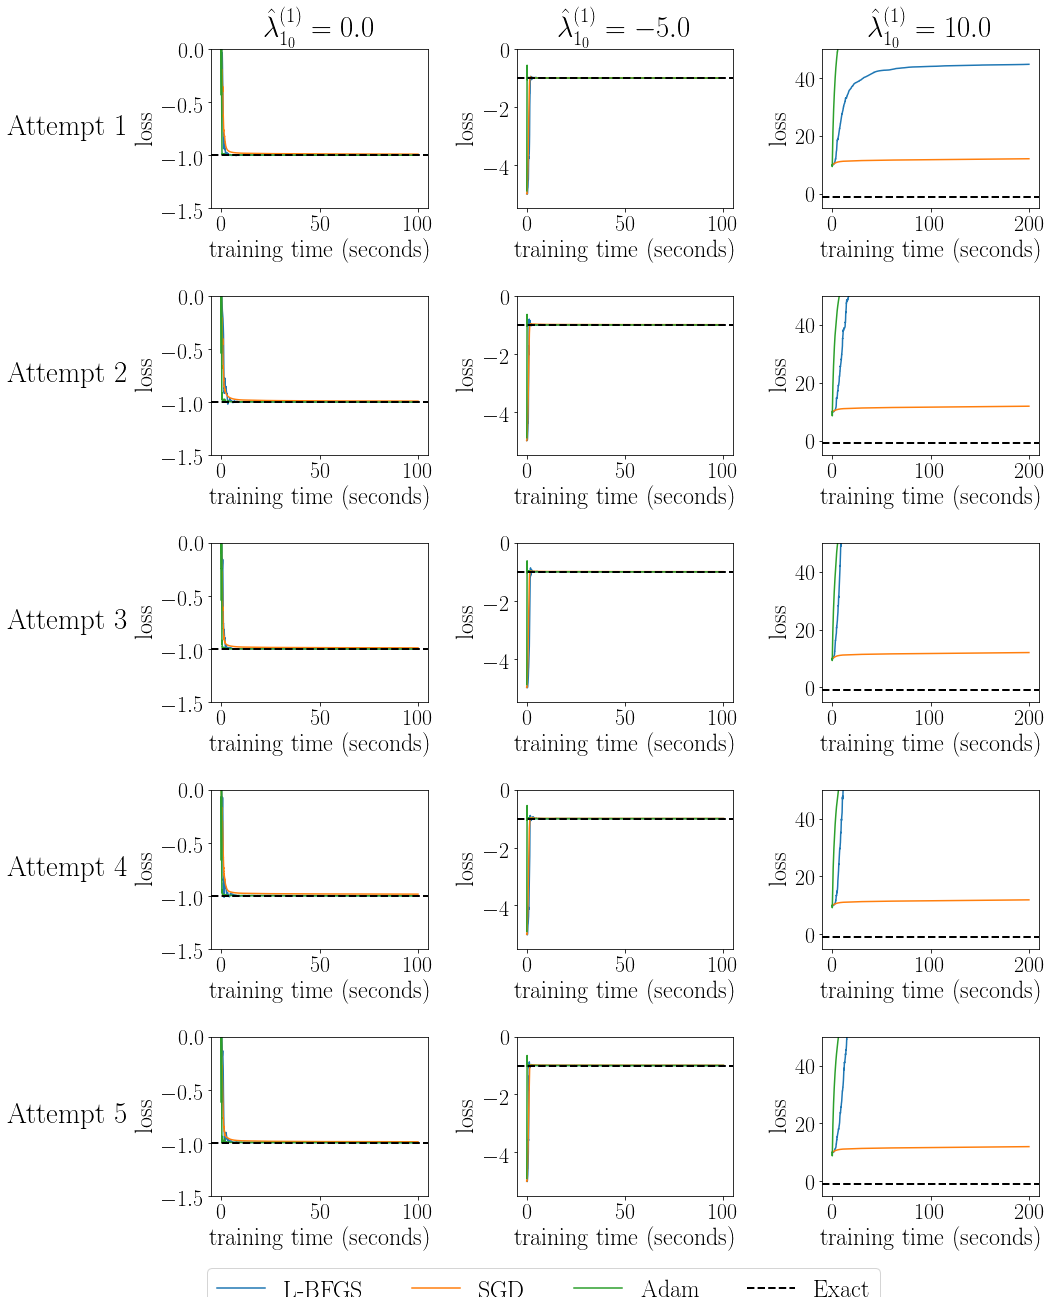

In [ ]:
fig, axes = plt.subplots(nrows=n_models, ncols=3, figsize=(15.1,18))

for i in range(n_models):
  timeout = 100
  axes[i,0].plot(np.linspace(0, timeout, len(hists_LBFGS[i][0][0])), hists_LBFGS[i][0][0])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_SGD[i][0][0])), hists_SGD[i][0][0])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_Adam[i][0][0])), hists_Adam[i][0][0])
  axes[i,0].set_ylim([-1.5,0])

  axes[i,1].plot(np.linspace(0, timeout, len(hists_LBFGS[i][1][0])), hists_LBFGS[i][1][0])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_SGD[i][1][0])), hists_SGD[i][1][0])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_Adam[i][1][0])), hists_Adam[i][1][0])
  axes[i,1].set_ylim([-5.5,0])

  timeout = 200
  axes[i,2].plot(np.linspace(0, timeout, len(hists_LBFGS[i][2][0])), hists_LBFGS[i][2][0])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_SGD[i][2][0])), hists_SGD[i][2][0])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_Adam[i][2][0])), hists_Adam[i][2][0])
  axes[i,2].set_ylim([-5,50])

timeout = 100
cols = ['$\hat{\lambda}_{1_0}^{(1)} = 0.0$', '$\hat{\lambda}_{1_0}^{(1)} = -5.0$', '$\hat{\lambda}_{1_0}^{(1)} = 10.0$']
rows = ['Attempt {}'.format(row) for row in range(1, n_models+1)]

pad = 5 # in points

for ax_row in axes:
  for ax in ax_row:
    ax.set_xlabel('training time (seconds)')
    ax.set_ylabel('loss')
    ax.axhline(y=-1, c="black",linewidth=2,linestyle='--')

for ax, col in zip(axes[0], cols):
  ax.annotate(col, xy=(0.5, 1.05), xytext=(0, pad),
              xycoords='axes fraction', textcoords='offset points',
              size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
  ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
              xycoords=ax.yaxis.label, textcoords='offset points',
              size='large', ha='right', va='center')

# fig.suptitle('Riwayat Tebakan Parameter pada \nLima Model yang Dikembangkan', y=1.05, fontsize=25)

# fig.subplots_adjust(left=0.01, top=0.6)
fig.tight_layout()
fig.legend(['L-BFGS', 'SGD', 'Adam', 'Exact'], loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=4, frameon=True)

# plt.savefig('heat_eqn_inv_hists.pdf', dpi=600, bbox_inches='tight', facecolor='none')
# plt.savefig('heat_eqn_inv_hists.png', dpi=600, bbox_inches='tight', facecolor='none')

plt.show()

## Analisis Hasil Prediksi

In [ ]:
def lambdas(hists, iter_model, iter_init, N=500):
  return sum(hists[iter_model][iter_init][0][-N:].tolist()) / N

df = pd.DataFrame(columns = ['L-BFGS_0', 'SGD_0', 'Adam_0',
                             'L-BFGS_1', 'SGD_1', 'Adam_1',
                             'L-BFGS_2', 'SGD_2', 'Adam_2'])

for i in range(n_models):
  x = []
  for j in range(len(initial_lambdas)):
    x.append(lambdas(hists_LBFGS, i, j))
    x.append(lambdas(hists_SGD, i, j))
    x.append(lambdas(hists_Adam, i, j))

  df.loc['Attempt '+str(i+1)] = x

df

,L-BFGS_0,SGD_0,Adam_0,L-BFGS_1,SGD_1,Adam_1,L-BFGS_2,SGD_2,Adam_2
Attempt 1,-1.000210,-0.990310,-1.000511,-1.000000,-0.997376,-1.000474,44.676849,12.087043,89.086001
Attempt 2,-1.000429,-0.991413,-1.000211,-0.999626,-0.991037,-1.000266,79.844293,11.881104,103.669328
Attempt 3,-1.000011,-0.990272,-1.000848,-0.999842,-0.995016,-1.000303,102.440598,12.059423,86.209023
Attempt 4,-1.000079,-0.984722,-1.000166,-0.999021,-0.993205,-1.000267,86.617476,11.909382,102.407320
Attempt 5,-0.999991,-0.992110,-1.000564,-0.999826,-0.992454,-0.999988,90.394137,11.937849,99.391000


In [ ]:
print(df.mean(axis=0))
df.loc['Average'] = df.mean(axis=0)

L-BFGS_0    -1.000144
SGD_0       -0.989766
Adam_0      -1.000460
L-BFGS_1    -0.999663
SGD_1       -0.993818
Adam_1      -1.000260
L-BFGS_2    80.794671
SGD_2       11.974960
Adam_2      96.152534
dtype: float64


In [ ]:
print(tabulate(df.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrrrrrrrr}
\hline
           &   L-BFGS\_0 &   SGD\_0 &   Adam\_0 &   L-BFGS\_1 &   SGD\_1 &   Adam\_1 &   L-BFGS\_2 &   SGD\_2 &   Adam\_2 \\
\hline
 Attempt 1 &    -1.0002 & -0.9903 &  -1.0005 &    -1.0000 & -0.9974 &  -1.0005 &    44.6768 & 12.0870 &  89.0860 \\
 Attempt 2 &    -1.0004 & -0.9914 &  -1.0002 &    -0.9996 & -0.9910 &  -1.0003 &    79.8443 & 11.8811 & 103.6693 \\
 Attempt 3 &    -1.0000 & -0.9903 &  -1.0008 &    -0.9998 & -0.9950 &  -1.0003 &   102.4406 & 12.0594 &  86.2090 \\
 Attempt 4 &    -1.0001 & -0.9847 &  -1.0002 &    -0.9990 & -0.9932 &  -1.0003 &    86.6175 & 11.9094 & 102.4073 \\
 Attempt 5 &    -1.0000 & -0.9921 &  -1.0006 &    -0.9998 & -0.9925 &  -1.0000 &    90.3941 & 11.9378 &  99.3910 \\
 Average   &    -1.0001 & -0.9898 &  -1.0005 &    -0.9997 & -0.9938 &  -1.0003 &    80.7947 & 11.9750 &  96.1525 \\
\hline
\end{tabular}


## *Training* Model *Hybrid*

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [0.0, -5.0, 10.0]
path = dir + "/model weights/heat_eqn_inv"

models = [None] * n_models
models_Adam = [None] * n_models
hists_Adam = [None] * n_models


for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.Hybrid_IdentificationNet(initial_lambda=0.0, lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

  models_Adam[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    print('{:s}\nIteration: {:d} Initial lambda: {}\n{:s}'.format(50*'-',i+1,initial_lambdas[j],50*'-'))
    models_Adam[i].append(pinn.Hybrid_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i][j].build((None, 2))

    # Copy weights from the previous model instance to make every iteration comparable
    models_Adam[i][j].set_weights(models[i].get_weights())

    # Assigning initial lambda
    models_Adam[i][j].initial_lambda = initial_lambdas[j]

    # Prepare optimizer for learning given data
    optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Prepare optimizer for minimizing PDE function and finding PDE parameters
    optim_inv_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Initialize solver
    solver_hybrid = pinn.Hybrid_IdentificationSolver(models_Adam[i][j], X_d, fun_r, get_r)

    # Train models
    print('\n\nAdam\n')
    solver_hybrid.solve(optim_Adam, optim_inv_Adam, get_r_param, X_param, u_param,
                        timeout_param=timeout*0.2, timeout=timeout*0.8)

    # Store evolution of lambdas and hists
    hists_Adam[i].append(np.array([models_Adam[i][j].lambd_list, solver_hybrid.hist]))

    print('\n\n\n')

--------------------------------------------------
Iteration: 1 Initial lambda: 0.0
--------------------------------------------------


Adam

Initial Learning Rate = 1.00000e-01
It 00000: l_u = 7.70811367e+00 loss = 7.70811367e+00
It 00050: l_u = 4.86300625e-02 loss = 4.86300625e-02
It 00100: l_u = 4.38092789e-03 loss = 4.38092789e-03
It 00150: l_u = 2.33833794e-03 loss = 2.33833794e-03
It 00200: l_u = 1.51923893e-03 loss = 1.51923893e-03
It 00250: l_u = 1.20170321e-02 loss = 1.20170321e-02
It 00300: l_u = 1.52171985e-03 loss = 1.52171985e-03
It 00350: l_u = 9.55815252e-04 loss = 9.55815252e-04
It 00400: l_u = 7.23004632e-04 loss = 7.23004632e-04
It 00450: l_u = 5.84482623e-04 loss = 5.84482623e-04
It 00500: l_u = 4.92322957e-04 loss = 4.92322957e-04
It 00550: l_u = 4.25209902e-04 loss = 4.25209902e-04
It 00600: l_u = 3.73436254e-04 loss = 3.73436254e-04
It 00650: l_u = 3.39327613e-03 loss = 3.39327613e-03
It 00700: l_u = 4.90973529e-04 loss = 4.90973529e-04
It 00750: l_u = 4.00761637

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Streaming output truncated to the last 5000 lines.
It 04550: l_u = 4.70591185e-05 loss = 4.70591185e-05
It 04600: l_u = 4.64866462e-05 loss = 4.64866462e-05
It 04650: l_u = 4.59135808e-05 loss = 4.59135808e-05
It 04700: l_u = 1.37591167e-04 loss = 1.37591167e-04
It 04750: l_u = 4.61879135e-05 loss = 4.61879135e-05
It 04800: l_u = 4.46941267e-05 loss = 4.46941267e-05
It 04850: l_u = 4.41536868e-05 loss = 4.41536868e-05
It 04900: l_u = 4.36226219e-05 loss = 4.36226219e-05
It 04950: l_u = 4.30942491e-05 loss = 4.30942491e-05
It 05000: l_u = 4.26773877e-05 loss = 4.26773877e-05
It 05050: l_u = 7.75328590e-05 loss = 7.75328590e-05
It 05100: l_u = 4.19595344e-05 loss = 4.19595344e-05
It 05150: l_u = 4.13900088e-05 loss = 4.13900088e-05
It 05200: l_u = 4.08905908e-05 loss = 4.08905908e-05
It 05250: l_u = 4.03979866e-05 loss = 4.03979866e-05
It 05300: l_u = 1.33241861e-04 loss = 1.33241861e-04
It 05350: l_u = 4.02706646e-05 loss = 4.02706646e-05
It 05400: l_u = 3.94841591e-05 loss = 3.94841591

In [ ]:
def lambdas(hists, iter_model, iter_init, N=500):
  return sum(hists[iter_model][iter_init][0][-N:]) / N

df = pd.DataFrame(columns = ['Adam_0','Adam_1','Adam_2'])

for i in range(n_models):
  x = []
  for j in range(len(initial_lambdas)):
    x.append(lambdas(hists_Adam, i, j))

  df.loc['Attempt '+str(i+1)] = x

df

,Adam_0,Adam_1,Adam_2
Attempt 1,-0.906663,-0.908812,-0.909444
Attempt 2,-0.930717,-0.926635,-0.931234
Attempt 3,-0.914794,-0.920105,-0.921664
Attempt 4,-0.949585,-0.947415,-0.949183
Attempt 5,-0.800823,-0.800850,-0.799337


In [ ]:
print(df.mean(axis=0))
df.loc['Average'] = df.mean(axis=0)

Adam_0   -0.900516
Adam_1   -0.900763
Adam_2   -0.902172
dtype: float64


In [ ]:
print(tabulate(df.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrr}
\hline
           &   Adam\_0 &   Adam\_1 &   Adam\_2 \\
\hline
 Attempt 1 &  -0.9067 &  -0.9088 &  -0.9094 \\
 Attempt 2 &  -0.9307 &  -0.9266 &  -0.9312 \\
 Attempt 3 &  -0.9148 &  -0.9201 &  -0.9217 \\
 Attempt 4 &  -0.9496 &  -0.9474 &  -0.9492 \\
 Attempt 5 &  -0.8008 &  -0.8008 &  -0.7993 \\
 Average   &  -0.9005 &  -0.9008 &  -0.9022 \\
\hline
\end{tabular}


### Export Model

In [ ]:
path = dir + "/model weights/heat_eqn_inv_hybrid"

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    models_Adam[i][j].save_weights(path+"/model_Adam_hy_"+str(i)+"_"+str(j)+".h5", 'h5')

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    np.savetxt(path+"/loss and param/hist_Adam_hy_"+str(i)+"_"+str(j)+".txt", hists_Adam[i][j][0])

### *Import* Model

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [0.0, -5.0, 10.0]
path = dir + "/model weights/heat_eqn_inv_hybrid"

models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models

for i in range(n_models):
  models_Adam[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i][j].build((None, 2))
    models_Adam[i][j].load_weights(path+"/model_Adam_hy_"+str(i)+"_"+str(j)+".h5", 'h5')

    hists_Adam[i].append(np.loadtxt(path+"/loss and param/hist_Adam_hy_"+str(i)+"_"+str(j)+".txt"))